# Qutrit classifier




In [2]:
import numpy as np

#Plots
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize


#optimization method
from scipy.optimize import minimize


#For computing the gradients 
from scipy.optimize import rosen, rosen_der
from scipy.optimize.optimize import approx_fprime


In [24]:

class qutrit_classifier: 
    def __init__(self, qutrits, layers, num_params, problem_name,problem_type = None, params = None, num_samples =100, seed = 7):

        """Class that implements data re-uploading using qutits for classification task.
        
        Args: 
        - qutrits (int): number of qutrits used for the model. Options: one qutrit or two qutrits. 
        - layers (int): number of layers used in the circuit ansatz. 
        - num_params (int): In each layer, how many params we will be using on the gate that encodes the data-points(x) and the parameters.
        - problem_type (str): options
                -'classification' : given a 2-d dataset, we will use this points to train and test a classification problem. 
                - 'fit': given a 1-d dataset of points, we will try to fit a function """

        np.random.seed(seed)
        #Number of parameters used in each layer of the quantum circuit
        self.num_params = num_params 
        self.probelm_type = problem_type
        self.problem_name = problem_name
        self.qutrits = qutrits
        self.layers = layers 
        self.num_samples = num_samples
        self.training_set = self.generate_datapoints()
        self.testing_set = self.generate_datapoints()
        if params == None:
            self.params = np.random.uniform(size=(self.layers+1,self.qutrits, self.num_params))
        else: 
            self. params =  np.concatenate((np.array(opt_params).reshape(int(len(params[0])/(self.num_params*self.qutrits)),self.qutrits,self.num_params),
                                            np.random.uniform(size=(self.layers - int(len(params[0])/(self.num_params*self.qutrits)) ,self.qutrits, self.num_params))))
        self.targets = self.target_states()


    def generate_datapoints(self):
        """
        Generates a dataset of points with 1/0 labels inside a given radius.

        Args:
            samples (int): number of samples to generate
            center (tuple): center of the circle
            radius (float): radius of the circle

        Returns:
            Xvals (array[tuple]): coordinates of points
            yvals (array[int]): classification labels
        """
        
        name = self.problem_name
        samples = self.num_samples

        x = 1-2*np.random.rand(samples, 2)
        labels = np.zeros(samples, dtype=np.int32)

        if name == '3cat':
            ids_1 = np.where(np.linalg.norm(x - ([0.5,0.3]), axis = 1) < 0.6)
            labels[ids_1] = 1


            ids_2 = np.where(np.linalg.norm(x - ([-0.7,-0.6]), axis = 1) < 0.7)
            labels[ids_2] = 2

        
        else: 
            print('problem not defined')
                
            #Then we append 
        return x,labels

  

    def gates(name, param = None): 
        """
        
        This function implements the diferents gates for qutrits that we are going to use in the qutrit classifier.
        There are single-qutrit gates. Especifically, we are using what is called two-qutrit gate. For example, 
        Ry_01 is the conventional Ry single-qubit gate that acts on the state 0 and 1 of the qutrit, not rotating 
        any angle in the state 2.
        There is also a two-qutrit gate: the TCX gate. This is a generalization of the CNOT gate and acts in the following form: 
        TCX = |0><0| X^{01}+ |1><1| X^{02}+|2><2| X^{12}, 
        introducing entanglement between the two qutrits """


        j = 1j
        if name == 'Ry_01':
            gate = np.array([[np.cos(param/2),np.sin(param/2), 0], 
                            [-np.sin(param/2), np.cos(param/2), 0], 
                            [0,0,1]], dtype='complex')
        elif name == 'Ry_02': 
            gate = np.array([[np.cos(param/2),0,np.sin(param/2)],[0,1,0], [-np.sin(param/2),0, np.cos(param/2)] ], dtype='complex')
        elif name == 'Rz_01': 
            gate = np.array([[np.exp(j*param/2),0,0],[0,np.exp(-j*param/2),0], [0,0,1] ], dtype='complex')
        elif name == 'Rz_02': 
            gate = np.array([[np.exp(j*param/2),0,0],[0,1,0], [0,0,np.exp(-j*param/2)] ], dtype='complex')
        elif name == 'X_01': 
            gate = np.array([[0,1,0],[1,0,0], [0,0,1]], dtype='complex')
        elif name == 'X_02': 
            gate = np.array([[0,0,1],[0,1,0], [1,0,0]], dtype='complex')
        elif name == 'X_12': 
            gate = np.array([[1,0,0],[0,0,1], [0,1,0]], dtype='complex')

            #Two-qubit gate.
        elif name == 'TCX':
            ket_zero = np.array([[1,0,0]],dtype='complex')
            ket_one = np.array([[0,1,0]],dtype='complex')
            ket_two = np.array([[0,0,1]],dtype='complex')
            X_01 = np.array([[0,1,0],[1,0,0], [0,0,1]], dtype='complex')
            X_02 = np.array([[0,0,1],[0,1,0], [1,0,0]], dtype='complex')
            X_12 = gate = np.array([[1,0,0],[0,0,1], [0,1,0]], dtype='complex')
            gate = np.kron(np.dot(ket_zero.T, ket_zero),X_01)+ np.kron(np.dot(ket_one.T, ket_one),X_02)+ np.kron(np.dot(ket_two.T, ket_two),X_12)
        return gate


    
    
    def general_unitary(self, angles):
        """
       Unitary with different number of parameters. 
       
       Args: 
       angles: parameters on the quantum gates. 
       
       Returns: 
       final_unitary: parameterized quantum gate.  """

        unitary = np.dot(qutrit_classifier.gates('Ry_01', param= angles[0]), qutrit_classifier.gates('Ry_02', param= angles[1]))

        if self.num_params==2:
            final_unitary = unitary
        elif self.num_params==3:
            final_unitary = np.dot(unitary, qutrit_classifier.gates('Rz_01', param= angles[2]))
        elif self.num_params==4:
            unitary = np.dot(unitary, qutrit_classifier.gates('Ry_01', param= angles[2]))
            final_unitary=    np.dot(unitary, qutrit_classifier.gates('Rz_01', param= angles[3]))
        elif self.num_params==5:
            unitary = np.dot(unitary, qutrit_classifier.gates('Ry_01', param= angles[2]))
            unitary = np.dot(unitary, qutrit_classifier.gates('Rz_01', param= angles[3]))
            final_unitary = np.dot(unitary, qutrit_classifier.gates('Rz_02', param= angles[4]))
        elif self.num_params==6:
            unitary = np.dot(unitary, qutrit_classifier.gates('Ry_01', param= angles[2]))
            unitary = np.dot(unitary, qutrit_classifier.gates('Rz_01', param= angles[3]))
            unitary = np.dot(unitary, qutrit_classifier.gates('Rz_02', param= angles[4]))
            final_unitary = np.dot(unitary, qutrit_classifier.gates('Ry_01', param= angles[5]))
        elif self.num_params==7:
            unitary = np.dot(unitary, qutrit_classifier.gates('Ry_01', param= angles[2]))
            unitary = np.dot(unitary, qutrit_classifier.gates('Rz_01', param= angles[3]))
            unitary = np.dot(unitary, qutrit_classifier.gates('Rz_02', param= angles[4]))
            unitary = np.dot(unitary, qutrit_classifier.gates('Ry_01', param= angles[5]))
            final_unitary = np.dot(unitary,qutrit_classifier.gates('Ry_02', param= angles[6]))
        elif self.num_params==8:
            unitary = np.dot(unitary, qutrit_classifier.gates('Rz_01', param= angles[2]))
            unitary = np.dot(unitary, qutrit_classifier.gates('Rz_02', param= angles[3])) #canviar 2 per 3 si vols unitaria general
            unitary = np.dot(unitary, qutrit_classifier.gates('Rz_02', param= angles[4]))
            unitary = np.dot(unitary, qutrit_classifier.gates('Ry_01', param= angles[5]))
            unitary = np.dot(unitary,qutrit_classifier.gates('Ry_02', param= angles[6]))
            final_unitary = np.dot(unitary,qutrit_classifier.gates('Ry_01', param= angles[7])) 
        return final_unitary    


    def ansatz_d1(self, angles): 
            state = np.dot(qutrit_classifier.gates('Ry_01', angles[0]), qutrit_classifier.gates('Rz_02', angles[1]))
            state = np.dot(qutrit_classifier.gates('Ry_02', angles[2]), state)
            state = np.dot(qutrit_classifier.gates('Rz_01', angles[3]), state)
            return state


    def target_states(self):
        """Creates the quantum states for computing the fidelity in the cost function. Each 
            state is associated to a category of the classification. 

            Returns:
                - targets (list of arrays): list that contain all the quantum states needed for the classification. 

            """

        name = self.problem_name
        if name == 'circle':
            targets = [np.array([1, 0,0], dtype='complex'),
                      np.array([0, 1, 0], dtype='complex')]
        elif name == '3cat':
            if self.qutrits== 1:
                targets = [np.array([1, 0,0], dtype='complex'),
                            np.array([0, 1, 0], dtype='complex'), 
                            np.array([0,0,1], dtype = 'complex')]
            elif self.qutrits == 2:
                targets = [np.array([1,0,0,0,0,0,0,0,0], dtype='complex'),
                            np.array([0,1,0,0,0,0,0,0,0], dtype='complex'), 
                            np.array([0,0,1,0,0,0,0,0,0], dtype = 'complex')] 

        elif name == '3_circles' or name == '_3_circles': 
            targets = [np.array([1, 0], dtype=complex),
                    np.array([1 / np.sqrt(3), np.sqrt(2 / 3)], dtype=complex),
                    np.array([1 / np.sqrt(3), np.exp(1j * 2 * np.pi / 3)
                                * np.sqrt(2 / 3)], dtype=complex),
                    np.array([1 / np.sqrt(3), np.exp(-1j * 2 * np.pi / 3) * np.sqrt(2 / 3)], dtype=complex)]
        return targets

    def fidelity(st1, st2):
        """This function computes the fidelity between two quantum states. 
        Args: 
        - st1, st2: states
        Returns: 
        - Fidelity between states. """
        return np.sum(np.abs(np.dot(st1, st2))**2)
    

    def circuit(self, x, initial_state = None): 
        """
        This function simulates the quantum circuit of a qutrit
        Args: 
        - x (array): single data-point of the problem. It has to have dim 8
        - params 
        Returns: 
        - state (array): quantum state after the application of the unitaries that form the circuit ansatz"""
        if initial_state == None:
            initial_state = np.array([1,0,0], dtype = 'complex')
            if self.qutrits==2: 
                initial_state = np.kron(initial_state, initial_state)
        
        state = initial_state
        params = self.params
        state = np.dot(self.general_unitary(params[0][0]), state)

        if self.qutrits ==1: 
            for p in params[1:]:
                for p_i in p:
                    state = np.dot(qutrit_classifier.gates('Ry_01', x[0]), state)
                    state = np.dot(qutrit_classifier.gates('Ry_02', x[1]), state)
                    state = np.dot(self.general_unitary(p_i), state)
                    

        if self.qutrits==2:
            for p in params:
                for idx, p_i in enumerate(p):
                    if idx ==0:
                        state = np.dot(np.kron(self.general_unitary(x), np.identity(3)), state)
                        state = np.dot(np.kron(self.general_unitary(p_i), np.identity(3)), state)
                        state = np.dot(qutrit_classifier.gates('TCX'), state)
                    if idx ==1: 
                        state = np.dot(np.kron(np.identity(3),self.general_unitary(x)), state)
                        state = np.dot(np.kron(np.identity(3),self.general_unitary(p_i)), state)

    
        return state


    def cost(self, params = None):
        """This function computes the normalized sum of the fidelities between the label state for the classification and the state obtained
        via passing the data through the circuit (with the given params). 

        Args: 
         -params: The params will be updated after each step of the minimization method. 
        Returns: 
        - Value of the cost function. 
        """

        if params is not None: 
            self.params = params.reshape(self.layers+1,self.qutrits, self.num_params)
        loss = 0.0
        state_labels = self.targets
        for x,y in zip(self.training_set[0], self.training_set[1]):
            state  = self.circuit(x)
            fid = qutrit_classifier.fidelity(state, state_labels[y])
            loss += (1-fid)**2
        loss/=len(self.training_set[0]) 
        return loss

    def minimize_funct(self,method='bfgs', options=None, compile = True):
        """"This function minimizes the cost function in the space of the parameters. Then 
        it returns the value of the function when the optimization has finished and the 
        values of the parameters that acomplish the desired optimization."""

        exact = []
        approx = []
        def callback(x):
           exact.append(rosen_der(x))
           approx.append(approx_fprime(x, rosen, 1E-8))


        
        m = minimize(lambda p: self.cost(p), x0 =self.params,
                    method = method, options=options, callback=callback)

        #fun: values of objective functions (què vol dir?)
        result = m.fun

        #x: solution of the optimization
        parameters = m.x

        return result, parameters, exact, approx

    def eval_train_set_fidelity(self, params_opt):
        """This function returns the labels of the classification states predicted for each data-point. 
        INPUTS: 
        -X: array of all points. 
        -parameters_opt: Parameters used in the single-qubit classifier circuit. 
        OUTPUT: 
        - labels: list with the predicted label."""
        targets = self.targets
        params_opt = params_opt.reshape(self.layers+1, self.qutrits, self.num_params)
        self.params = params_opt
        
        labels = np.zeros(len(self.training_set[1]))
        for i,x in enumerate(self.training_set[0]):
            fidelities = []
            state = self.circuit(x)
            for targ in targets:
                fidelities.append(qutrit_classifier.fidelity(state,targ))
            labels[i] = np.argmax(fidelities)
        return labels

    def eval_test_set_fidelity(self,params_opt):
        """This function returns the labels of the classification states predicted for each data-point. 
        INPUTS: 
        -X: array of all points. 
        -parameters_opt: Parameters used in the single-qubit classifier circuit. 
        OUTPUT: 
        - labels: list with the predicted label."""
        targets = self.targets
        self.params = params_opt
        
        labels = np.zeros(len(self.testing_set[1]))
        for i,x in enumerate(self.training_set[0]):
            fidelities = []
            state = self.circuit(x)
            for targ in targets:
                fidelities.append(qutrit_classifier.fidelity(state,targ))
            labels[i] = np.argmax(fidelities)
        return labels


    def accuracy_score(y_pred, y_real):
        """Function for printing the resuls""""

        score = y_pred == y_real
        return score.sum() / len(y_real)

    def paint_results(self, params_opt): 
        params_opt = params_opt.reshape(self.layers+1,self.qutrits, self.num_params)
        fig, axs = plt.subplots(ncols=2, figsize=(9, 4))

        for ax in axs:
             if self.problem_name == '3cat': 
                 circle1 = plt.Circle((0.5,0.3), 0.6,
                         color='black', fill=False, zorder=10)
                 ax.add_artist(circle1)
                 circle2 = plt.Circle((-0.7,-0.6), 0.7,
                         color='black', fill=False, zorder=10)
                 ax.add_artist(circle2)

                
        guessed_labels = self.eval_test_set_fidelity(params_opt)
        X = self.training_set[0]
        x1, x2 = X[:,0], X[:,1]
        colors_classes = get_cmap('tab10')
        norm_class = Normalize(vmin=0, vmax=10)
        axs[0].scatter(x1, x2, c=guessed_labels, s=2,
                        cmap=colors_classes, norm=norm_class)
        
        colors_rightwrong = get_cmap('RdYlGn')
        norm_rightwrong = Normalize(vmin=-.1, vmax=1.1)
        checks = [int(g == l) for g, l in zip(guessed_labels, self.training_set[1])]
        axs[1].scatter(x1, x2, c=checks, s=2,
                cmap=colors_rightwrong, norm=norm_rightwrong)
        accuracy = 100.00 * np.sum(checks) / len(checks)
        print('The accuracy for this classification is %.2f' %
            (100 * np.sum(checks) / len(checks)), '%')
        res = [accuracy, self.qutrits, self.layers, self.layers*2*self.qutrits,self.layers*self.num_params*self.qutrits]
        fig.suptitle('Accuracy: {:.2f} % | Qutrits:{:2d} | Layers: {:2d} | Gates: {:2d} | Parameters: {:2d}'.format(*res))
        return accuracy


LAYER 1
0.49836595054794014
0.49836595085655466
0.4983659517310555
0.49836595054794014
0.49836595118429405
0.4983659515148417
0.49836595040420717
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.98366D-01    |proj g|=  1.18312D-01
0.3867345591299393


 This problem is unconstrained.


0.38673455824541125
0.3867345600080238
0.3867345591299393
0.3867345583887928
0.38673455999697093
0.3867345592345892

At iterate    1    f=  3.86735D-01    |proj g|=  8.84528D-02
0.5418563283028814
0.5418563272233211
0.5418563265988845
0.5418563283028814
0.5418563279082453
0.5418563271880242
0.5418563279499262
0.338989881525052
0.3389898806702006
0.3389898819592447
0.33898988152505205
0.33898988082296105
0.3389898821103237
0.3389898816191655

At iterate    2    f=  3.38990D-01    |proj g|=  8.54851D-02
0.33319258308297517
0.3331925826394004
0.3331925819368846
0.33319258308297517
0.3331925829042424
0.3331925823235659
0.3331925830057083

At iterate    3    f=  3.33193D-01    |proj g|=  1.14609D-01
0.3065626769959111
0.3065626771230474
0.3065626769111346
0.3065626769959111
0.3065626771195727
0.3065626771422772
0.30656267693469186

At iterate    4    f=  3.06563D-01    |proj g|=  1.46366D-02
0.3054660924058298
0.3054660924276988
0.3054660922823012
0.3054660924058298
0.3054660924580821
0.305

 This problem is unconstrained.


0.35358036973255386
0.35358036950421096
0.3535803699660544
0.3535803700539078
0.3535803692483876
0.3535803701843372
0.35358037027409484
0.35358036920547803
0.3535803691018836
0.3535803693787306
0.3535803692835185
0.35358036947393817

At iterate    1    f=  3.53580D-01    |proj g|=  8.64171D-02
0.3550271640225785
0.35502716468044865
0.3550271633968151
0.35502716402257845
0.3550271637213969
0.35502716436419923
0.3550271636878024
0.3550271642833819
0.35502716372851556
0.35502716395334916
0.35502716401920165
0.35502716383827104
0.3550271642145617
0.4606471843075857
0.4606471858263944
0.46064718494838275
0.4606471843075858
0.46064718562289164
0.4606471854593746
0.4606471842584112
0.46064718386329595
0.46064718598679966
0.46064718398388255
0.46064718477910627
0.46064718548377626
0.4606471851478545
0.3080111866901161
0.3080111869717221
0.3080111866736007
0.30801118669011607
0.3080111871855195
0.30801118649153003
0.308011186841027
0.3080111869771924
0.3080111866343481
0.30801118595862825
0.308

 This problem is unconstrained.


0.33696253543688814
0.3369625358541321
0.33696253576258933
0.3369625354368879
0.3369625356592315
0.3369625357871307
0.3369625353035988
0.3369625354116818
0.3369625357737628
0.33696253539422166
0.3369625354594402
0.3369625355214775
0.3369625355283158
0.3369625359995794
0.33696253529350356
0.3369625353630172
0.3369625360470382
0.33696253517029545
0.3369625351950729

At iterate    1    f=  3.36963D-01    |proj g|=  6.10150D-02
0.312665910696663
0.312665910669315
0.3126659107368507
0.312665910696663
0.31266591062187005
0.31266591070950644
0.31266591059885274
0.3126659105904261
0.31266591070500804
0.31266591058596566
0.3126659107261943
0.312665910604837
0.31266591050456644
0.31266591085272233
0.3126659105119911
0.3126659102997121
0.3126659107934577
0.31266591040460223
0.3126659103487277

At iterate    2    f=  3.12666D-01    |proj g|=  3.96951D-02
0.29895631740414647
0.2989563171880572
0.29895631734887945
0.2989563174041464
0.2989563172158923
0.2989563172451943
0.29895631746131995
0.2989563

 This problem is unconstrained.


0.36984031291940167
0.3698403128146437
0.36984031274647905
0.36984031291940145
0.3698403127050022
0.3698403128011865
0.36984031291155595
0.36984031261804756
0.3698403129275588
0.36984031278612556
0.3698403127354685
0.3698403131566459
0.36984031257048533
0.36984031289764613
0.3698403132791787
0.3698403124070818
0.3698403128799389
0.3698403133236951
0.3698403126158367
0.3698403128520299
0.36984031322226085
0.36984031280722923
0.36984031285815705
0.36984031299006304
0.3698403127512415

At iterate    1    f=  3.69840D-01    |proj g|=  5.12320D-02
0.34782050396588593
0.347820503899989
0.34782050384646984
0.347820503965886
0.3478205038323873
0.3478205038725898
0.34782050380647006
0.347820503732566
0.347820503836992
0.34782050377587875
0.3478205039862977
0.3478205038390754
0.3478205036540874
0.34782050416494914
0.3478205038254072
0.3478205035052702
0.34782050407699894
0.34782050385943913
0.34782050374892504
0.34782050401252756
0.3478205038109195
0.3478205040151267
0.3478205039836868
0.3478205

 This problem is unconstrained.


0.39459727896313446
0.3945972789103277
0.3945972786346357
0.39459727896313457
0.39459727897044405
0.39459727865729166
0.394597278737182
0.39459727892754287
0.39459727867816236
0.3945972786639872
0.3945972789845745
0.39459727869829975
0.3945972787161211
0.39459727900763925
0.39459727878345663
0.394597278704387
0.39459727899623714
0.39459727882252965
0.39459727860738036
0.3945972789241231
0.3945972787623676
0.39459727864488753
0.39459727886849777
0.39459727873549
0.39459727877935546
0.3945972788439005
0.39459727871751266
0.3945972789774044
0.39459727875161277
0.394597278636116
0.39459727891693147

At iterate    1    f=  3.94597D-01    |proj g|=  3.55754D-02
0.3672076818104046
0.3672076817806611
0.3672076816123761
0.3672076818104044
0.367207681774796
0.3672076816392027
0.36720768166316103
0.36720768171771256
0.36720768164132755
0.3672076817441526
0.3672076817571472
0.36720768162162876
0.3672076818855379
0.3672076818634004
0.36720768177755914
0.3672076817847866
0.36720768189486175
0.367207

 This problem is unconstrained.


0.4093714813982878
0.40937148162052034
0.40937148158983616
0.40937148139828755
0.40937148156255593
0.4093714816840067
0.40937148154775377
0.4093714816626902
0.40937148186817
0.4093714814142731
0.4093714817017894
0.4093714821263444
0.4093714811859139
0.4093714814951629
0.40937148181542166
0.40937148129874074
0.4093714813968297
0.4093714818067521
0.409371482001403
0.40937148137279405
0.409371481818024
0.4093714819404083
0.409371481425669
0.4093714817306083
0.40937148157245196
0.40937148147747837
0.40937148156753117
0.40937148139386237
0.40937148139929624
0.40937148134291906
0.40937148117798833
0.40937148129061496
0.4093714813280069
0.40937148114046995
0.4093714810962423
0.4093714813651053
0.4093714814996831

At iterate    1    f=  4.09371D-01    |proj g|=  7.28057D-02
0.46961445966779314
0.4696144589903335
0.4696144583733403
0.46961445966779297
0.46961445899642773
0.4696144584516953
0.46961445985886785
0.46961445917238404
0.4696144586750138
0.4696144597218157
0.4696144594102901
0.4696144

 This problem is unconstrained.


0.3925934669723591
0.3925934667573677
0.3925934671893191
0.39259346697235925
0.3925934667809786
0.39259346729540817
0.3925934666541125
0.39259346675586554
0.3925934673015487
0.39259346698436864
0.3925934670591124
0.3925934671797656
0.3925934671980814
0.3925934673757547
0.3925934670869498
0.3925934668159686
0.3925934673870332
0.39259346712154436
0.39259346680916873
0.3925934674377792
0.39259346722787825
0.39259346705558384
0.39259346742163587
0.39259346700619185
0.3925934670280459
0.3925934673247193
0.392593466887636
0.3925934672478329
0.39259346676714835
0.3925934664913125
0.3925934670259965
0.3925934667391961
0.3925934664585141
0.39259346705314996
0.3925934669964143
0.39259346638412823
0.3925934669499083
0.39259346733696093
0.3925934664759399
0.3925934668700245
0.39259346743081563
0.3925934663813006
0.39259346683781987

At iterate    1    f=  3.92593D-01    |proj g|=  5.91058D-02
0.32634628966309964
0.32634628933480825
0.3263462896907919
0.32634628966309953
0.32634628929198584
0.32634

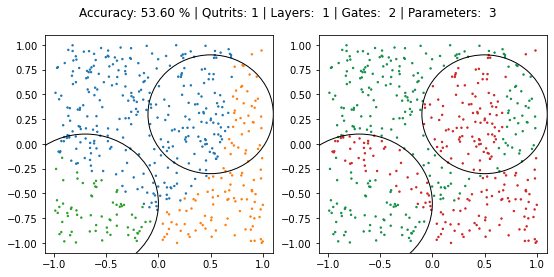

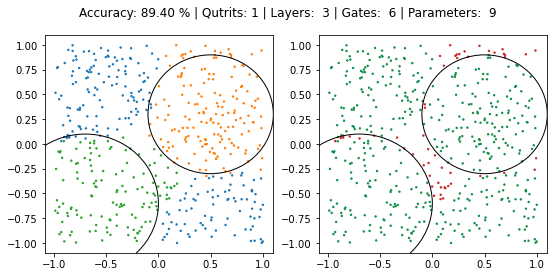

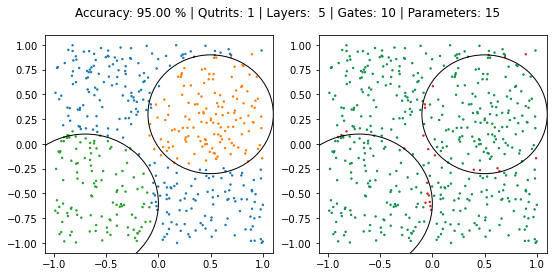

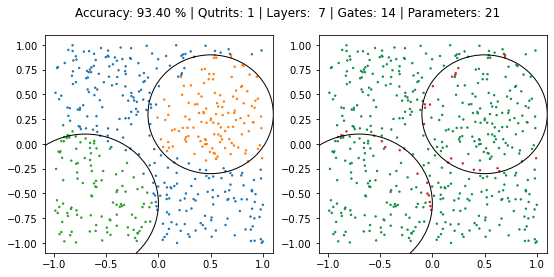

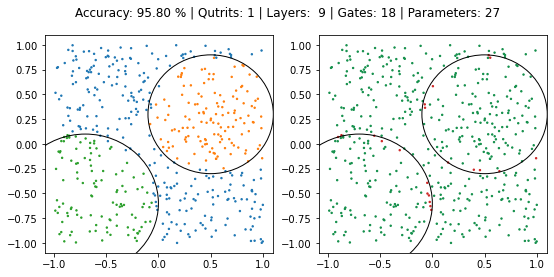

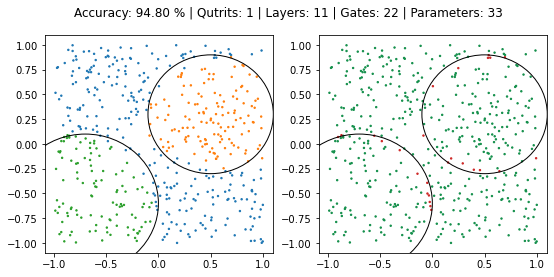

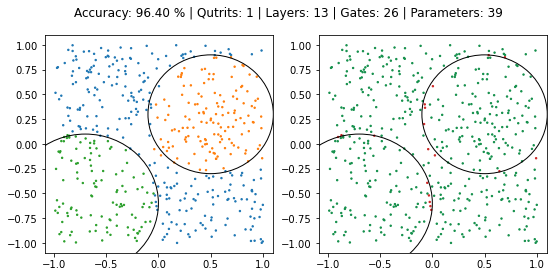

In [36]:


layer_test = [x for x in range(1,15,2)]
qutrit_class = []
for layer in layer_test:
    qutrit_class.append(qutrit_classifier(qutrits=1, layers = layer, num_params=3, problem_name='3cat'))

result = [0]*len(layer_test)
opt_params = [0]*len(layer_test)
exact_grad = [0]*len(layer_test)
approx_grad = [0]*len(layer_test)
accuracy = [0]*len(layer_test)

#Nelder-Mead
#BGFS
#L-BFGS-B

for i in range(len(layer_test)):
    print('LAYER', layer_test[i])
    result[i], opt_params[i], exact_grad[i], approx_grad[i] = qutrit_class[i].minimize_funct(method='L-BFGS-B', options={'disp': True, 'maxiter': 100}, compile = True)
for i in range(len(layer_test)):
    accuracy[i] = qutrit_class[i].paint_results(params_opt = opt_params[i])

LAYER 1
0.4989566799944623
0.4989566787905496
0.4989566799944624
0.49895667975526126
0.49895667964052465
0.4989566799944623
0.4989566799944623
0.4989566799944623
0.4989566799944623
0.49895668001338656
0.49895667872652083
0.4989566799631492
0.4989566792920859
0.4989566792148574
0.49895667993929055
0.4989566794949852
0.4989566794172237
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.98957D-01    |proj g|=  1.26794D-01
0.4059748536723683


 This problem is unconstrained.


0.40597485394094435
0.4059748536723683
0.4059748541630902
0.40597485396158256
0.4059748536723683
0.4059748536723683
0.4059748536723683
0.4059748536723683
0.40597485420308743
0.40597485345475476
0.4059748543032645
0.4059748530114028
0.4059748538412043
0.4059748545413833
0.4059748534739581
0.4059748542667328

At iterate    1    f=  4.05975D-01    |proj g|=  8.69015D-02
0.34731709986528286
0.34731710032433044
0.3473170998652829
0.3473171001001459
0.3473170999732566
0.34731709986528286
0.34731709986528286
0.34731709986528286
0.34731709986528286
0.34731709980613557
0.3473170996715973
0.3473170999624837
0.34731709943198313
0.3473170999460818
0.34731710055620474
0.3473170997331515
0.3473171004747073

At iterate    2    f=  3.47317D-01    |proj g|=  6.90922D-02
0.30066979787841325
0.3006697977724893
0.3006697978784132
0.3006697974974231
0.3006697985066369
0.30066979787841325
0.30066979787841325
0.30066979787841325
0.30066979787841325
0.30066979787185777
0.3006697977365813
0.30066979809186645
0

 This problem is unconstrained.


0.35715220027381955
0.3571522001010109
0.35715220027381944
0.3571521991854376
0.35715220061558534
0.35715220027381955
0.35715220027381955
0.35715220027381955
0.35715220027381955
0.35715219972148515
0.3571521993046535
0.3571521996584626
0.3571522005079109
0.35715220022180616
0.35715219961218064
0.3571521993364854
0.35715219941240317
0.3571522000097097
0.35715219928858366
0.3571522000320804
0.35715219992697955
0.3571521996763348
0.3571522000329731
0.3571521993160065
0.35715219997198816
0.35715220012272186
0.3571521996112281
0.3571522000860498
0.357152200250529
0.35715220022449623
0.3571522001105702
0.35715219940897963
0.35715220031335654

At iterate    1    f=  3.57152D-01    |proj g|=  1.08838D-01
0.312935876055201
0.3129358766322928
0.3129358760552009
0.31293587593284383
0.3129358760879671
0.312935876055201
0.312935876055201
0.312935876055201
0.312935876055201
0.3129358762599304
0.31293587586330524
0.31293587631802516
0.31293587635050873
0.3129358765223895
0.31293587649024845
0.3129358

 This problem is unconstrained.


0.24351204430373405
0.24351204411999247
0.2435120443037341
0.24351204358218934
0.24351204438804946
0.24351204430373405
0.24351204430373405
0.24351204430373405
0.24351204430373405
0.24351204411116947
0.24351204380604258
0.243512044167589
0.24351204427865727
0.24351204415955904
0.24351204397192186
0.24351204372633373
0.24351204389966474
0.24351204404442667
0.24351204390881973
0.2435120440852381
0.24351204384511055
0.2435120439300227
0.24351204417438463
0.2435120438988014
0.24351204418536035
0.24351204401209606
0.24351204412242758
0.24351204393389386
0.2435120445122979
0.24351204452066985
0.24351204397618317
0.24351204402565796
0.24351204409402605
0.24351204429383883
0.24351204449517647
0.24351204419810213
0.24351204412077337
0.24351204425377904
0.24351204403230883
0.243512044210762
0.2435120440253086
0.2435120438184577
0.24351204446133753
0.2435120438329861
0.24351204430278722
0.24351204411383945
0.24351204408520333
0.24351204457201298
0.2435120442101405

At iterate    1    f=  2.43512D-

 This problem is unconstrained.


0.32432402239886593
0.32432402337514343
0.32432402239886593
0.32432402212271905
0.3243240229228914
0.32432402239886593
0.32432402239886593
0.32432402239886593
0.32432402239886593
0.32432402262657933
0.3243240228840754
0.3243240227472639
0.3243240225559992
0.32432402271447
0.3243240224123799
0.32432402202037436
0.324324022754269
0.32432402269794086
0.32432402277861244
0.3243240226349158
0.3243240216966999
0.32432402140277206
0.3243240226273374
0.3243240229215223
0.3243240226146942
0.32432402292209433
0.3243240218066515
0.32432402293018675
0.3243240226599835
0.32432402255986403
0.32432402307936276
0.3243240223999314
0.32432402290912743
0.32432402299532603
0.3243240223576924
0.32432402301102314
0.32432402259841847
0.3243240224564029
0.32432402297946633
0.32432402180681946
0.32432402302172153
0.32432402218076617
0.3243240229168517
0.3243240223361362
0.3243240218815816
0.3243240214589505
0.3243240225502951
0.3243240228848847
0.3243240229468546
0.3243240227942397
0.32432402284259093
0.324324

 This problem is unconstrained.


0.38421052424973023
0.38421052425417324
0.38421052424973023
0.3842105253806032
0.38421052367913316
0.38421052424973023
0.38421052424973023
0.38421052424973023
0.38421052424973023
0.3842105250412649
0.38421052448666326
0.3842105249991773
0.38421052389662186
0.3842105248430512
0.3842105249874229
0.38421052526652166
0.38421052500590386
0.384210525140727
0.3842105243183661
0.384210525120464
0.384210523883703
0.38421052530632765
0.3842105250646261
0.38421052430061764
0.3842105250031853
0.38421052473053513
0.3842105245183283
0.3842105247289427
0.38421052488696944
0.3842105254237784
0.3842105252187581
0.38421052401065287
0.3842105252708279
0.3842105248724029
0.38421052430341585
0.3842105248671327
0.38421052503762054
0.3842105254314235
0.3842105248112473
0.38421052450700555
0.38421052482727364
0.38421052464578925
0.38421052390826693
0.3842105246940776
0.3842105239989777
0.3842105249627724
0.3842105250726805
0.3842105241942099
0.38421052498442804
0.3842105245058672
0.38421052499946334
0.3842105

 This problem is unconstrained.


0.4523691292946028
0.4523691297200046
0.4523691292946028
0.4523691280711568
0.4523691293700329
0.4523691292946028
0.4523691292946028
0.4523691292946028
0.4523691292946028
0.4523691286016277
0.4523691291914611
0.4523691289391113
0.4523691290885001
0.4523691287770718
0.45236912894281694
0.45236912830508047
0.4523691292585453
0.4523691284396474
0.45236912956674585
0.45236912847927235
0.4523691289468296
0.4523691284344172
0.4523691285563876
0.45236912937263385
0.4523691287206833
0.45236912887600345
0.4523691289729153
0.45236912889014774
0.452369129643618
0.4523691294173505
0.45236912867979057
0.45236912965725945
0.45236912858074446
0.452369129170179
0.4523691288562706
0.4523691291676502
0.4523691284248677
0.452369128796839
0.4523691289083674
0.4523691288617986
0.4523691288919437
0.4523691282239291
0.4523691299809918
0.45236912828338893
0.45236912938181567
0.452369128677415
0.45236912881898195
0.4523691290255541
0.4523691290792887
0.4523691291445939
0.45236912920156946
0.4523691287987398
0.

 This problem is unconstrained.


0.34999706101862954
0.34999706017038384
0.34999706101862976
0.34999706243653456
0.34999706069956305
0.34999706101862954
0.34999706101862954
0.34999706101862954
0.34999706101862954
0.34999706166284167
0.3499970610433257
0.3499970612543128
0.3499970606344659
0.34999706145082765
0.34999706134576386
0.34999706209639764
0.34999706094442457
0.34999706179774137
0.3499970605634179
0.34999706177326495
0.34999706123326774
0.3499970616881272
0.34999706175216594
0.3499970608384805
0.3499970615758954
0.34999706148494636
0.34999706069169806
0.3499970614712316
0.3499970616251821
0.34999706182653767
0.34999706169455125
0.3499970606507428
0.34999706179559525
0.349997061860363
0.34999706100831934
0.34999706186935986
0.34999706155506133
0.34999706207421155
0.34999706145543624
0.34999706080047177
0.34999706153835286
0.34999706050079893
0.34999706139185993
0.3499970606709733
0.34999706080575005
0.34999706160575916
0.34999706141551706
0.34999706158325705
0.3499970618126436
0.3499970606675063
0.3499970617749

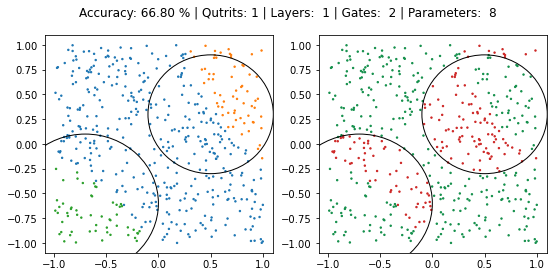

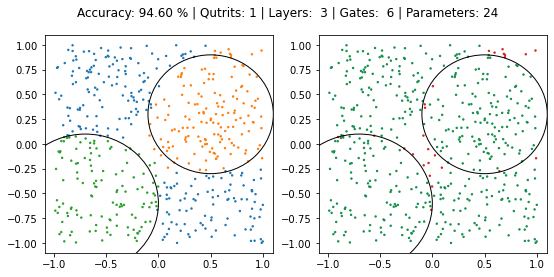

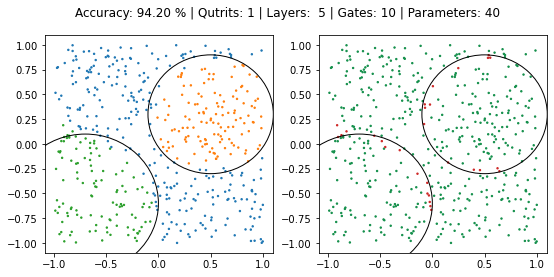

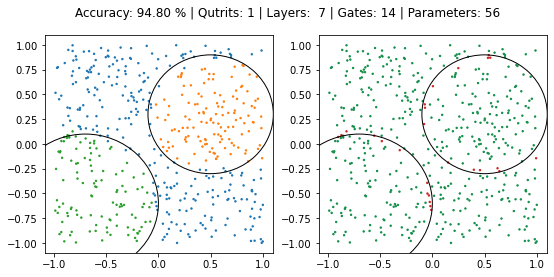

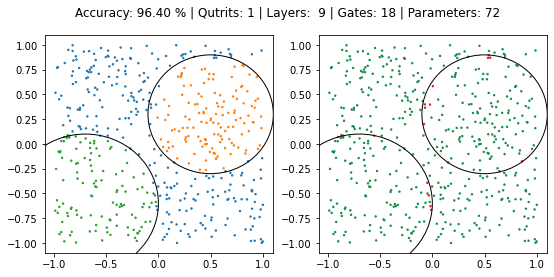

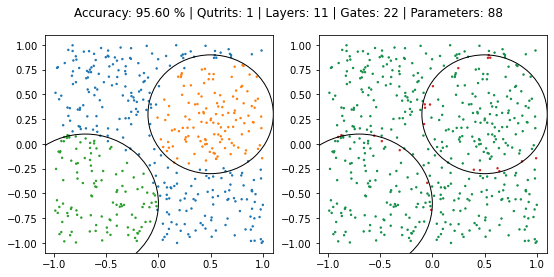

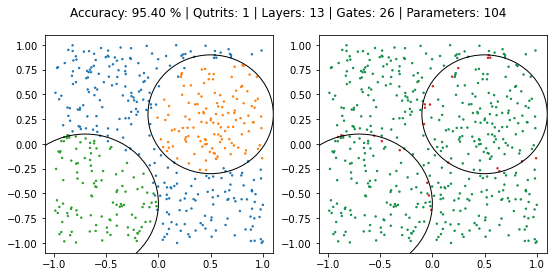

In [13]:
#layer_test = [3,5,10]
layer_test = [x for x in range(1,15,2)]
qutrit_class = []
for layer in layer_test:
    qutrit_class.append(qutrit_classifier(qutrits=1, layers = layer, num_params=8, problem_name='3cat'))

result = [0]*len(layer_test)
opt_params = [0]*len(layer_test)
exact_grad = [0]*len(layer_test)
approx_grad = [0]*len(layer_test)
accuracy = [0]*len(layer_test)

#Nelder-Mead
#BGFS
#L-BFGS-B

for i in range(len(layer_test)):
    print('LAYER', layer_test[i])
    result[i], opt_params[i], exact_grad[i], approx_grad[i] = qutrit_class[i].minimize_funct(method='L-BFGS-B', options={'disp': True, 'maxiter': 100}, compile = True)
for i in range(len(layer_test)):
    accuracy[i] = qutrit_class[i].paint_results(params_opt = opt_params[i])